## Install dependencies

### Prerequisites

You will need to install OpenCV. The easiest way to do this is from the Anaconda environment. The newest version might work, but 4.7.0 worked for this notebook. You will also need [tesserocr](https://pypi.org/project/tesserocr/) for doing optical character recognition (OCR). Version 2.5.2 was verified working for this notebook.

```
conda install -c conda-forge opencv=4.7.0 tesserocr=2.5.2
```

Finally, you will need to install PyTorch for Stable Baselines3 to work. It is highly recommended that you use the GPU-enabled version of PyTorch for faster training. Follow the directions here: https://pytorch.org/get-started/locally/. This notebook was tested with the following:
 * PyTorch v2.0.0
 * OS: Windows
 * Package: Conda
 * Language: Python
 * Compute platform: CUDA 11.7

### Install packages

Uncomment the following cells to install the required packages. Note the versions on some of them. Gymnasium and Stable-Baselines3 change constantly, so I tried to version-lock these packages, as these are known to work with this notebook. Starting with v2.0.0, Stable-Baselines3 will only support gymnasium (and drop gym support). See [here](https://github.com/DLR-RM/stable-baselines3/releases/tag/v1.8.0) for more information.

### Play game

Navigate to [this web version of FlappyBird](https://flappybird.io/) using Chrome. Make sure bookmark bar is disabled. Move the window to the top-left corner of the screen. Make sure zoom is set to 100%. Resize the width to the smallest possible. Resize the height so that the scroll bar just barely disappears. If any of the sizing in the tests below look incorrect, adjust `GAME_CROP` and `DONE_CROP`.

In [38]:
# !python -m pip install mss pynput 
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.0.0a1
# !python -m pip install wandb

In [39]:
# Screen capture
from mss import mss

# Keyboard and mouse control
import pynput

# Image manipulation
import cv2

# Optical character recognition (OCR)
from PIL import Image
import tesserocr

# Environment wrapper
import gymnasium as gym

# Reinforcement learning framework
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger
from stable_baselines3 import PPO

# Weights & Biases for remote logging
import wandb

# Other
import time
import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from typing import Any, Dict, Tuple, Union

## Test screen capture

In [40]:
# Create screen capture object
screen = mss()

In [97]:
# Game observation (minimum 36x36 for default CnnPolicy)
GAME_CROP = {
    'top':160, 
    'left':0, 
    'width':505, 
    'height':595
}
GAME_RESIZE_WIDTH = 50
GAME_RESIZE_HEIGHT = 60
GAME_FRAME_STACK_SIZE = 4
OBS_DTYPE = np.uint8

In [100]:
def get_game_screen(screen):
    """Get screen grab, convert to grayscale, and resize"""

    # Get screen grab and drop alpha channel
    game_img = screen.grab(GAME_CROP)
    game_img = np.array(game_img)[:, :, :3]

    # Convert to grayscale and resize
    game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
    game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))
    
    return game_img

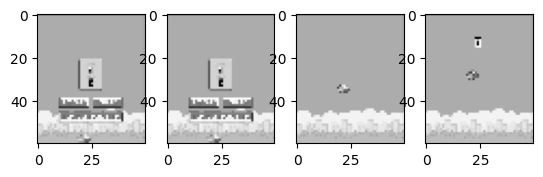

In [102]:
# Capture a full stack of frames
frame_stack = np.zeros((GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE))
for _ in range(GAME_FRAME_STACK_SIZE):

    # Roll frame stack and add new frame to the end
    img = get_game_screen(screen)
    frame_stack = np.roll(frame_stack, -1, axis=-1)
    frame_stack[:, :, -1] = img
    
    # Wait between frame captures
    time.sleep(1.0)
    
# Show frames
fig, axs = plt.subplots(1, GAME_FRAME_STACK_SIZE)
for i in range(GAME_FRAME_STACK_SIZE):
    axs[i].imshow(frame_stack[:, :, i], cmap='gray', vmin=0, vmax=255)

In [251]:
# Gymnasium will require us to define the observation space
observation_space = gym.spaces.Box(
    low=0,
    high=255,
    shape=(GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE),
    dtype=OBS_DTYPE
)

# Randomly sample from it to show that it matches our expected input screen capture
obs = observation_space.sample()
print(f"Shape: {obs.shape}")
print(f"Example row: {obs[0, :, 0]}")

Shape: (60, 50, 4)
Example row: [223 181 226 253  67 227 178 218 220 177 135  46 120 152  94  64  94 197
 242 153 151  17  23 209 156   7  92 185 212 192 252  60 171 180  24 135
  91 155  33 183  29 170 197  53 166 174 198  31 249 233]


## Test done screen OCR

In [221]:
# Game over screen settings
DONE_CROP = {
    'top':555, 
    'left':110, 
    'width':125, 
    'height':30}
DONE_RESIZE_WIDTH = 100
DONE_RESIZE_HEIGHT = 40
GAME_OVER_STRINGS = ["restart"]

In [222]:
# Create OCR context
ocr = tesserocr.PyTessBaseAPI()

In [223]:
def get_done_screen(sreen):
    """Capture part of game screen, extract string(s) with OCR"""
    
    # Get screen grab and drop alpha channel
    img = screen.grab(DONE_CROP)
    img = np.array(img)[:, :, :3]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img

OCR: 0.02868 sec
OCR string: RESTART
Done: True


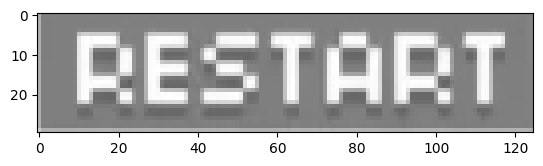

In [229]:
# Get done screen
timestamp = time.time()
img = get_done_screen(screen)

# Use tesserocr to get text from image
ocr_str = ""
try:
    pil_img = Image.fromarray(img)
    ocr.SetImage(pil_img)
    ocr_str = ocr.GetUTF8Text()
except:
    print("ERROR: Could not perform OCR")

# Check OCR results against known string(s)
done = False
ocr_str = ocr_str.strip()
if ocr_str:
    done_str = ocr_str.split()[0].lower()
    if done_str in GAME_OVER_STRINGS:
        done = True
        
# Display results
print(f"OCR: {(time.time() - timestamp):.5f} sec")
print(f"OCR string: {ocr_str}")
print(f"Done: {done}")

# Show image
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [230]:
# End OCR context
ocr.End()

# End screen grab context
screen.close()

## Test game control

In [338]:
# Game restart settings
RESTART_MOUSE_POS = (200, 700)
RESTART_PAUSE = 0.1
ACTIONS_MAP = {
    0: 'no-op',
    1: 'space'
}

In [339]:
# Gymnasium will require us to define the action space
action_space = gym.spaces.Discrete(len(ACTIONS_MAP))

# Sample from it to show that we can randomly generate a number corresponding to an action
action = action_space.sample()
print(f"{action}: {ACTIONS_MAP[action]}")

0: no-op


In [340]:
def restart_game(keyboard, mouse):
    """Simple routine to restart the game"""
    
    # Move mouse to game window and click to bring focus
    mouse.position = RESTART_MOUSE_POS
    mouse.press(pynput.mouse.Button.left)
    mouse.release(pynput.mouse.Button.left)

    # Press 'space' once to restart game
    keyboard.press(pynput.keyboard.Key.space)
    time.sleep(RESTART_PAUSE)
    keyboard.release(pynput.keyboard.Key.space)
    time.sleep(RESTART_PAUSE)
    
    # Press 'space' again to start the game
    keyboard.press(pynput.keyboard.Key.space)
    time.sleep(RESTART_PAUSE)
    keyboard.release(pynput.keyboard.Key.space)
    time.sleep(RESTART_PAUSE)

In [342]:
# Create interactions objects
keyboard = pynput.keyboard.Controller()
mouse = pynput.mouse.Controller()

# Restart the game
restart_game(keyboard, mouse)

# Randomly control game
for _ in range(10):
    
    # Release everything
    keyboard.release(pynput.keyboard.Key.space)
    
    # Perform random action
    action = action_space.sample()
    if ACTIONS_MAP[action] == 'space':
        keyboard.press(pynput.keyboard.Key.space)
    print(f"{action}: {ACTIONS_MAP[action]}")
    time.sleep(0.1)

1: space
0: no-op
1: space
0: no-op
1: space
1: space
0: no-op
1: space
1: space
0: no-op


## Build gymnasium environment

In [343]:
class WebGame(gym.Env):
    """
    Subclass gymnasium Env class
    
    This is the gym wrapper class that allows our agent to interact with our environment. We must
    implement four main methods: step(), reset(), render(), and close(). We should also define the
    action_space and observation space as class members.
    
    More information: https://gymnasium.farama.org/api/env/
    """
    
    # Set up the environment, action, and observation shapes
    def __init__(
        self, 
        score_multiplier=1.0,
        crash_reward=-100,
        fps_limit=0.0,
        display_scale=0.0
    ):
        
        # Call superclass's constructor
        super().__init__()
        
        # Assign attributes
        self.score_multiplier = score_multiplier
        self.crash_reward = crash_reward
        self.fps_limit = fps_limit
        self.display_scale = display_scale
        
        # Define the observation space
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE),
            dtype=OBS_DTYPE
        )
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
        
        # Screen capture object
        self.screen = mss()
        
        # OCR context
        self.ocr = tesserocr.PyTessBaseAPI()
        
        # Interaction objects
        self.keyboard = pynput.keyboard.Controller()
        self.mouse = pynput.mouse.Controller()
        
        # Keep track of FPS
        self.fps = 0.0
        self.timestamp = time.time()

        # Initialize game frame stack
        self.frame_stack = np.zeros(
            (GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE), 
            dtype=OBS_DTYPE
        )
        
        # Show rendering in new window if requested
        if self.display_scale > 0.0:
            cv2.namedWindow('Game Image')
        
    
    # What happens when you take a step in the game (e.g. each frame)
    def step(self, action):
        
        # Perform action
        if ACTIONS_MAP[action] == 'space':
            self.keyboard.press(pynput.keyboard.Key.space)

        # Get next observation, render, and add to frame stack
        frame_stack = self.get_observation()
        
        # Check if done, penalize agent for crashing, reward for staying alive
        terminated = self.get_done()
        if terminated:
            reward = self.crash_reward
        else:
            reward = self.score_multiplier
                
        # Calculate FPS and wait to meet FPS limit
        now = time.time()
        self.fps = 1 / (now - self.timestamp)
        if self.fps_limit > 0:
            to_wait = (1 / self.fps_limit) - (now - self.timestamp)
            if to_wait > 0:
                time.sleep(to_wait)
        self.timestamp = now
        
        # Return auxiliary information for debugging
        info = {'fps': self.fps}
            
        # Release all keys
        self.keyboard.release(pynput.keyboard.Key.space)
        
        # We're not timing out (truncating) game play
        truncated = False
        
        # Order of return values is important!
        return frame_stack, reward, terminated, truncated, info
    
    # Capture screen, perform color conversion and resizing
    def get_observation(self):
        
        # Roll frame stack and add new frame to the end
        img = get_game_screen(screen)
        self.frame_stack = np.roll(self.frame_stack, -1, axis=-1)
        self.frame_stack[:, :, -1] = img
        
        # Render final frame in stack
        self.render()
        
        return self.frame_stack
    
    # Visualize the game using OpenCV
    def render(self):
        
        # Only render if our display scale is >0
        if self.display_scale > 0:
            
            # Resize our game image to something that can be easily seen
            disp_width = int(GAME_RESIZE_WIDTH * self.display_scale)
            disp_height = int(GAME_RESIZE_HEIGHT * self.display_scale)
            disp_img = cv2.resize(
                self.frame_stack[:, :, -1],
                (disp_width, disp_height),
                interpolation=cv2.INTER_AREA
            )
            
            # Add FPS counter to image
            disp_img = cv2.putText(
                disp_img, 
                f"fps: {self.fps:.1f}", 
                (10, 25), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, 
                (255), 
                2, 
                cv2.LINE_AA
            )
                
            # Draw and wait 1 ms to prevent window crashing
            cv2.imshow('Game Image', disp_img)
            cv2.waitKey(1)
    
    # Determine if the game is done using OCR
    def get_done(self):
        
        # Capture screen
        img = get_done_screen(self.screen)
        
        # Use tesserocr to get text from image
        ocr_str = ""
        try:
            pil_img = Image.fromarray(img)
            self.ocr.SetImage(pil_img)
            ocr_str = self.ocr.GetUTF8Text()
        except:
            print("ERROR: Could not perform OCR")

        # Check OCR results against known string(s)
        done = False
        ocr_str = ocr_str.strip()
        if ocr_str:
            done_str = ocr_str.split()[0].lower()
            if done_str in GAME_OVER_STRINGS:
                done = True
                
        return done
    
    # Restart the game
    def reset(self):
        
        # Perform restart routine
        restart_game(self.keyboard, self.mouse)
        
        # Reinitialize frame stack and get first observation of new game
        self.frame_stack[:, :, :] = 0
        frame_stack = self.get_observation()
        
        # Reset FPS and timestamp
        self.fps = 0.0
        self.timestamp = time.time()
        
        # Return auxiliary information for debugging
        info = {'fps': self.fps}
        
        # Order of return values is important!
        return frame_stack, info
    
    # Close OpenCV windows, end MSS and OCR contexts
    def close(self):
        cv2.destroyAllWindows()
        self.ocr.End()
        self.screen.close()

## Test gymnasium Environment

In [344]:
# Create our environment
try:
    env.close()
except NameError:
    pass
env = WebGame(
    score_multiplier=0.1,
    crash_reward=-100,
    fps_limit=20.0,
    display_scale=5.0
)

In [345]:
# See if game is done
print(f"Done: {env.get_done()}")

Done: True


Shape: (60, 50, 4)


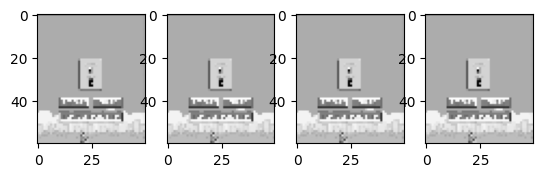

In [346]:
# Capture a few frames
for _ in range(GAME_FRAME_STACK_SIZE):
    frame_stack = env.get_observation()
    time.sleep(1.0)
    
# Show frames
print(f"Shape: {frame_stack.shape}")
fig, axs = plt.subplots(1, GAME_FRAME_STACK_SIZE)
for i in range(GAME_FRAME_STACK_SIZE):
    axs[i].imshow(frame_stack[:, :, i], cmap='gray', vmin=0, vmax=255)

In [347]:
# Do a few game loops
for ep in range(3):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    
    # Do a single game loop
    while not terminated and not truncated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
        
    # Show results
    print(f"Total reward for episode {ep} is {total_reward:.2f}")

Total reward for episode 0 is -87.90
Total reward for episode 1 is -88.00
Total reward for episode 2 is -87.70


In [349]:
# Final environment check to make sure it works with Stable Baselines3
env_checker.check_env(env)

## Checkpoint callback

In [350]:
# Checkpoint config
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_FREQ = 35_000 # About 30 min at 20 fps

In [351]:
class SaveCheckpointCallback(BaseCallback):
    """
    Save the model every ``check_freq`` steps
    
    More information: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """
    
    # Constructor
    def __init__(self, check_freq, save_dir, verbose=1):
        super(SaveCheckpointCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        
    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            
    # Save model every check_freq steps
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_dir, f"model_{self.n_calls}")
            self.model.save(model_path)
        return True

In [352]:
# Set up checkpoint callback
checkpoint_callback = SaveCheckpointCallback(
    check_freq=CHECKPOINT_FREQ, 
    save_dir=CHECKPOINT_DIR,
    verbose=1
)

## Custom Weights & Biases logger

In [364]:
# Weights & Biases project name
WANDB_PROJECT = "flappy-bird"

In [365]:
class WandBWriter(KVWriter):
    """
    Log metrics to Weights & Biases when called by .learn()
    
    More info: https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/logger.html#KVWriter
    """
    
    # Initialize run
    def __init__(self, run, verbose=1):
        super().__init__()
        self.run = run
        self.verbose = verbose

    # Write metrics to W&B project
    def write(self, 
              key_values: Dict[str, Any], 
              key_excluded: Dict[str, Union[str, Tuple[str, ...]]], 
              step: int = 0) -> None:
        log_dict = {}
        
        # Go through each key/value pairs
        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())):
            
            if self.verbose >= 2:
                print(f"step={step} | {key} : {value} ({type(value)})")
            
            # Skip excluded items
            if excluded is not None and "wandb" in excluded:
                continue
                
            # Log integers and floats
            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    wandb.log(data={key: value}, step=step)
                    log_dict[key] = value
                
        # Print to console
        if self.verbose >= 1:
            print(f"Log for steps={step}")
            print(f"--------------")
            for (key, value) in sorted(log_dict.items()):
                print(f"  {key}: {value}")
            print()
                
    # Close the W&B run
    def close(self) -> None:
        self.run.finish()

In [366]:
# Log in to Weights & Biases
wandb.login()

True

In [367]:
# Create new W&B run
config = {}
dt = datetime.datetime.now(datetime.timezone.utc)
dt = dt.replace(microsecond=0, tzinfo=None)
run = wandb.init(project=WANDB_PROJECT, name=str(dt), config=config)

# Print run info
print(f"WandB run ID: {run.id}")
print(f"WandB run name: {run.name}") 

WandB run ID: izqb7hw2
WandB run name: 2023-05-29 06:12:19


In [368]:
# Set custom logger with our custom writer
wandb_writer = WandBWriter(run, verbose=0)
loggers = Logger(
    folder=None,
    output_formats=[wandb_writer]
)

## Train model

In [370]:
# Hyperparameters
hparams = {
    "score_multiplier": 0.1,            # Low score per step
    "crash_reward": -100,               # Penalize crashing
    "fps_limit": 20,                    # Is actually ??? on Windows
    "learning_rate": 0.0003,            # Default is 0.0003
    "steps_per_update": 64,             # Default is 2048
    "entropy_coefficient": 0.0,         # Higher entropy encourages more exploration. Default is 0
    "total_timesteps": 600_00,          # About 8.3 hours at 20 fps
    "num_actions": len(ACTIONS_MAP),
    "model_name": "flappy-v01",
    "notes": "First try"
}

# Log hyperparameters to W&B
wandb.config.update(hparams)

In [371]:
# Create our environment with a timeout for training
try:
    env.close()
except NameError:
    pass
env = WebGame(
    score_multiplier=hparams["score_multiplier"],
    crash_reward=hparams["crash_reward"],
    fps_limit=hparams["fps_limit"],
    display_scale=5.0
)

In [372]:
# Create model
# More information: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
model = PPO('CnnPolicy', 
            env, 
            verbose=0,
            learning_rate=hparams["learning_rate"], 
            n_steps=hparams["steps_per_update"],
            ent_coef=hparams["entropy_coefficient"])

In [373]:
# Choo choo train!
model.set_logger(loggers)
model.learn(total_timesteps=hparams["total_timesteps"], 
            callback=[checkpoint_callback])

In [374]:
# Exit environment and close W&B run
env.close()
run.finish()

rollout/ep_len_mean,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,█▅▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/iterations,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/time_elapsed,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/total_timesteps,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/approx_kl,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/clip_fraction,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁███████████████████████████████████████
train/explained_variance,▁▆▇▄▇▆▇█▇██████▅███▇█████████████▅██████


In [375]:
# Save final model
model.save(hparams["model_name"])

## Test model

In [376]:
# Create our environment with a timeout for training
try:
    env.close()
except NameError:
    pass
env = WebGame(
    score_multiplier=hparams["score_multiplier"],
    crash_reward=hparams["crash_reward"],
    fps_limit=hparams["fps_limit"],
    display_scale=5.0
)

In [377]:
# Load model (use final model or any checkpoint)
model = PPO.load(
    os.path.join(".", hparams["model_name"]), 
    env=env, 
    print_system_info=True
)

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.22621-SP0 10.0.22621
- Python: 3.10.10
- Stable-Baselines3: 2.0.0a1
- PyTorch: 2.0.0
- GPU Enabled: True
- Numpy: 1.23.5
- Gym: 0.28.1

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.22621-SP0 10.0.22621
- Python: 3.10.10
- Stable-Baselines3: 2.0.0a1
- PyTorch: 2.0.0
- GPU Enabled: True
- Numpy: 1.23.5
- Gym: 0.28.1



In [378]:
# Play game
for ep in range(3):
    
    # Reset game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    step_count = 0
    
    # Perform actions based on observation and accumulate reward
    while not terminated and not truncated:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
        step_count += 1
        
    # Print total reward at the end of the episode
    print(f"Episode {ep} | Steps: {step_count}, Total reward: {total_reward}")

Episode 0 | Steps: 25, Total reward: -97.6
Episode 1 | Steps: 360, Total reward: -64.09999999999977
Episode 2 | Steps: 25, Total reward: -97.6


In [ ]:
# Close the environment
env.close()

## NOTE TO SELF: Use time as +reward